## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[(df.group == "treatment") & (df.landing_page != 'new_page')].count()['user_id'] + df[(df.group != "treatment") & (df.landing_page == 'new_page')].count()['user_id']

3893

f. Do any of the rows have missing values?

In [7]:
df.info()
# From the result, the answer is "No"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# We are going to drop the misaligned rows:
df2=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'])]['user_id']   # REF1

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2=df2.drop([1899], axis=0)   # REF2
df2.query('user_id == 773192')

user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2[(df2.landing_page == 'new_page')].count()['user_id']/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**We don't have enough evidence as the conversion probability of 'control' group is very near to 'treatment'.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0 : $p_{new}$ - $p_{old}$ $\le$ 0**

**H1 : $p_{new}$ - $p_{old}$ $\gt$ 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
# I didn't understand what is n_new stands for and she told me that it is the number of individuals in the treatment group.
treatment_group = df2.query('group == "treatment"')
n_new = treatment_group.user_id.count()
n_new

145310

d. What is $n_{old}$?

In [21]:
# I didn't understand what is n_old stands for and she told me that it is the number of individuals in the control group.
control_group = df2.query('group == "control"')
n_old = control_group.user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

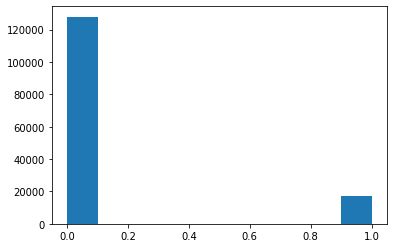

In [22]:
new_page_converted = np.random.choice([1,0] , n_new , p=[p_new,1-p_new])     #REF3
new_page_converted 
plt.hist(new_page_converted);

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

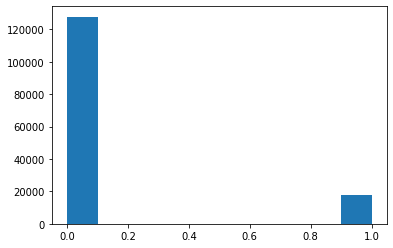

In [23]:
old_page_converted = np.random.choice([1,0] , n_old , p=[p_old,1-p_old])
old_page_converted 
plt.hist(old_page_converted);

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diffs = new_page_converted.mean() - old_page_converted.mean()
diffs

-0.0006285213519767463

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1,0] , n_new, p=[p_new, 1-p_new])
    old_page_converted = np.random.choice([1,0] , n_old, p=[p_old, 1-p_old])
    diffs = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diffs)

p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00023874,  0.00087226, -0.00060074, ..., -0.0004563 ,
        0.00082364, -0.00036721])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

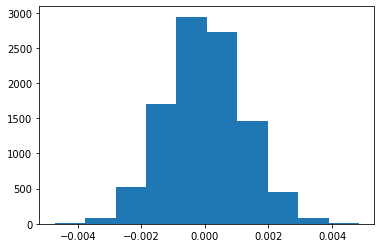

In [26]:
plt.hist(p_diffs);

* It is normal distribution as expected.
* Now, the next step should be calculating the actual difference and place it on the histogram to check whether the proportion of simulated difference values is smaller or greater than the actual difference.

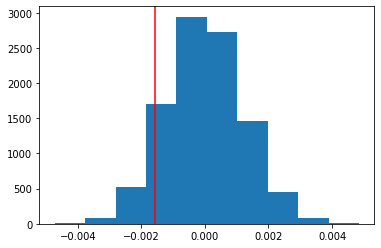

In [27]:
actual_diff = treatment_group.converted.mean() - control_group.converted.mean()
plt.hist(p_diffs);
plt.axvline(actual_diff, color= 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# The required is p-value

null_vals = np.random.normal(0, np.std(p_diffs), p_diffs.size)
p_value = (null_vals > actual_diff).mean()
p_value

0.903

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This value is called "p-value' and its value here is .8969 which is greater than alpha value (.05) significantly which means that we Failed to Reject the null hypothesis.hence, there is almost no diffirence between the old page and the new one**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df.query('group =="control"').converted.sum()
convert_new = df.query('group =="treatment"').converted.sum()
n_old = df.query('group =="control"').converted.count()
n_new = df.query('group =="treatment"').converted.count()
print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

17723
17514
147202
147276


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
# help link is not working so I refered to REF4
sm.stats.proportions_ztest(count = [convert_old, convert_new], nobs = [n_old, n_new], alternative = "smaller")

(1.2369217547321678, 0.8919419336512124)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Z-score focuses on standard deviation, while the P-value focuses on wheather to reject or accept a null hypothesis.**

REF5

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

REF6

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept']=1
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
logit_model = sm.Logit(df2.converted, df2[['intercept','ab_page']])
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:48:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**p-value = 0.190**

It is diffirent here than the one calculated in part II because here, it is based on statsmodels.api.Logit fn but in part II it was based on null values (np.random.normal fn).


Here, the hypotheses are:

**H0 : $p_{new}$ - $p_{old}$ = 0**

**H1 : $p_{new}$ - $p_{old}$ $\neq$ 0**

Here, p-value is still greater than alpha value (.05) which leads us to same result of part II (failed to reject the null hypothesis).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

* Adding other factors makes the model more reliable.
* Some factors may have effect on the significance of each other.

**From the a/m points, I'm sure it is a good idea to consider other factors to add into the regression model.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  
user_id                                 
834778           0          1        0  
928468           0          1        1  
822059           1          1        1  
711597           0          1        0  
710616           0          1        1

In [35]:
country_effect = df_new.query('converted == 1')
country_effect.groupby('country').count()


timestamp  group  landing_page  converted  intercept  ab_page
country                                                               
CA            1672   1672          1672       1672       1672     1672
UK            8739   8739          8739       8739       8739     8739
US           24342  24342         24342      24342      24342    24342

In [36]:
### Create the necessary dummy variables
df_new[['UK','US','CA']]= pd.get_dummies(df_new.country)
df_new=df_new.drop('CA',axis=1)
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  UK  US  
user_id                                         
834778           0          1        0   0   1  
928468           0          1        1   0   0  
822059           1          1        1   0   1  
711597           0          1        0   0   1  
710616           0          1        1   0   1

In [37]:
logit_new2 = sm.Logit(df_new.converted, df_new[['intercept','ab_page','UK','US']])
results = logit_new2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 08 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        17:48:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

### Notes
* Again, P-value here is still greater than alpha value 0.05 --> failed to reject the null hypothesis.
* For each one unit decrease in ab_page, the conversion rate is 1.015 times more likely holding all other variables constant.
* For For each one unit decrease in UK, the conversion rate is 0.41 times more likely holding all other variables constant.
* For each one unit increase in US, the conversion rate is 0.01 times more likely holding all other variables constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new['US_ab_page'] = df_new['US']*df_new['ab_page']
logit3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])

results = logit3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 Oct 2020   Pseudo R-squ.:               3.482e-05
Time:                        17:52:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
US_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

### Notes
* P-value is still greater than alpha value 0.05 --> failed to reject the null hypothesis.
* The effect of country is now more significant and clear especially for US.

<a id='conclusions'></a>
### Conclusion
* P-value here is greater than alpha value 0.05 --> failed to reject the null hypothesis.
* For each one unit decrease in ab_page, the conversion rate is 1.015 times more likely holding all other variables constant.
* For For each one unit decrease in UK, the conversion rate is 0.41 times more likely holding all other variables constant.
* For each one unit increase in US, the conversion rate is 0.01 times more likely holding all other variables constant.
* After adding the interaction between ab_page and country, the country effect is  now more significant and clear especially for US.


### Notes
* Kindly I need a reference for hypothesis tests; I'm very intereseted in this topic.


## Resources:

REF1 https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/#:~:text=To%20find%20%26%20select%20the%20duplicate,argument%20is%20'first').

REF2 https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/

REF3 https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

REF4 https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html

REF5
http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm#:~:text=The%20Z%20score%20is%20a,are%20measures%20of%20standard%20deviation.&text=Both%20statistics%20are%20associated%20with%20the%20standard%20normal%20distribution.

REF6 https://help.xlstat.com/s/article/which-statistical-model-should-you-choose?language=en_US
